# Filtrado de datos iniciales

* Se visualizan los puntos de Open Street Map sobre los mapas de comunas de Santiago y zonas pobladas de santiago.

* se filtran los puntos para  excluir ciertas comunas que salen del área de estudio (Buin, San José de Maioo, etc.).

In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point

from utils import networkx_graph_to_gdf

In [2]:
# Cargar puntos de interes
poi_df = pd.read_csv("../data/nodos_santiago.csv")
poi = gpd.GeoDataFrame(poi_df, geometry=[Point(xy) for xy in zip(poi_df["lon"], poi_df["lat"])], crs="EPSG:4326")

# comunas
comunas = gpd.read_file("../data/Comunas/comunas.shp")

In [3]:
# Join espacial para asignar comuna a cada punto de interés
comunas_proj = comunas.to_crs(epsg=3857)
poi_proj = poi.to_crs(epsg=3857)

poi_with_comuna = gpd.sjoin(
    poi_proj,
    comunas_proj[["Comuna", "geometry"]],
    how="inner",
    predicate="within"
)

# quedarnos solo con las comunas que sí recibieron al menos un POI
comunas_poi = comunas_proj.merge(
    poi_with_comuna[["Comuna"]].drop_duplicates(),
    on="Comuna",
    how="inner"
)

# Filtrar las comunas que no nos interesan
comunas_a_retirar = ['San José de Maipo', 'Pirque', 'Buin']
comunas_filtradas = comunas_poi[~comunas_poi['Comuna'].isin(comunas_a_retirar)]
comunas_interes = comunas_filtradas['Comuna'].unique()
poi_filtrado = poi_with_comuna[poi_with_comuna['Comuna'].isin(comunas_interes)]

In [4]:
# cargar grafo y crear GeoDataFrame
G = nx.read_gexf("../data/grafo_OSM/grafo_santiago.gexf")
gdf_nodes = networkx_graph_to_gdf(G)

if comunas_filtradas.crs is None:
    raise ValueError("Tu GeoDataFrame comunas_filtradas no tiene CRS definido. Asigna uno antes de plotear.")
    
if comunas_filtradas.crs != gdf_nodes.crs:
    gdf_nodes = gdf_nodes.to_crs(comunas_filtradas.crs)

/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 421 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


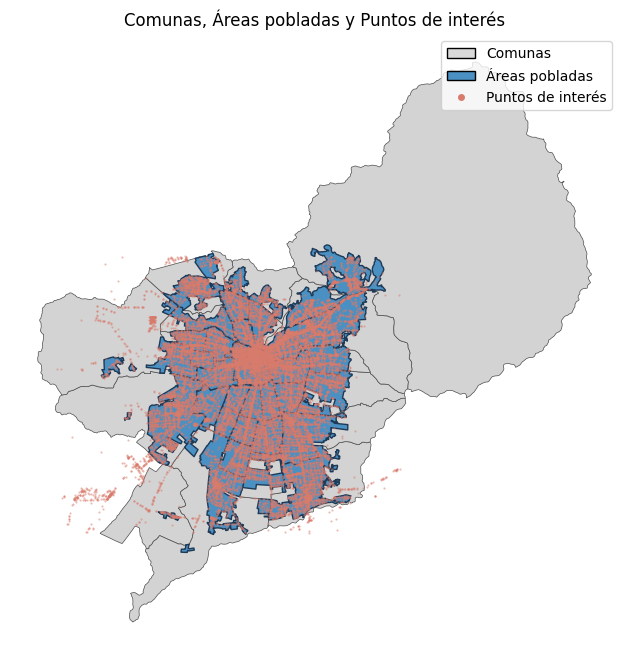

In [5]:
areas_pobladas = gpd.read_file("../data/Areas_Pobladas/Areas_Pobladas.shp")
areas_pobladas = areas_pobladas[areas_pobladas['comuna'].isin(comunas_interes)]

fig, ax = plt.subplots(figsize=(8, 8))
comunas_filtradas.plot(color="lightgray", edgecolor="#4d4d4d", linewidth=0.5, ax=ax)
areas_pobladas.plot(ax=ax, edgecolor="#1f3a56", alpha=1, color='#4a90c2')
gdf_nodes.plot(ax=ax, markersize=0.3, alpha=0.5, color='#d97b6c')

comunas_patch = mpatches.Patch(facecolor="#d9d9d9", edgecolor="black", label="Comunas")
areas_patch   = mpatches.Patch(facecolor="#4a90c2", edgecolor="black", label="Áreas pobladas")
scatter_handle = plt.Line2D([], [], marker='o', linestyle='None', markersize=4, color='#d97b6c', label="Puntos de interés")

ax.legend(handles=[comunas_patch, areas_patch, scatter_handle], loc="best")

ax.set_title("Comunas, Áreas pobladas y Puntos de interés")
ax.set_axis_off()
plt.show()

In [6]:
area_union = comunas_filtradas.unary_union
gdf_nodes["inside"] = gdf_nodes.geometry.within(area_union)
gdf_nodes_clip = gdf_nodes[gdf_nodes["inside"]].copy()
nodos_validos = set(gdf_nodes_clip["node_id"])

G_clip = G.subgraph(nodos_validos).copy()
nodos_aislados = [n for n in G_clip.nodes() if G_clip.degree(n) == 0]
G_clip.remove_nodes_from(nodos_aislados)

print(f"Nodos originales: {G.number_of_nodes()}")
print(f"Aristas originales: {G.number_of_edges()}")
print(f"Nodos dentro de comunas: {G_clip.number_of_nodes()}")
print(f"Aristas dentro de comunas: {G_clip.number_of_edges()}")
print(f'Se eliminó el {(1 - G_clip.number_of_nodes() / G.number_of_nodes()) * 100:.2f}% de los nodos y el {(1 - G_clip.number_of_edges() / G.number_of_edges()) * 100:.2f}% de las aristas del grafo original.')

/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_55161/3813016537.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_union = comunas_filtradas.unary_union


Nodos originales: 30171
Aristas originales: 304498
Nodos dentro de comunas: 29267
Aristas dentro de comunas: 303540
Se eliminó el 3.00% de los nodos y el 0.31% de las aristas del grafo original.


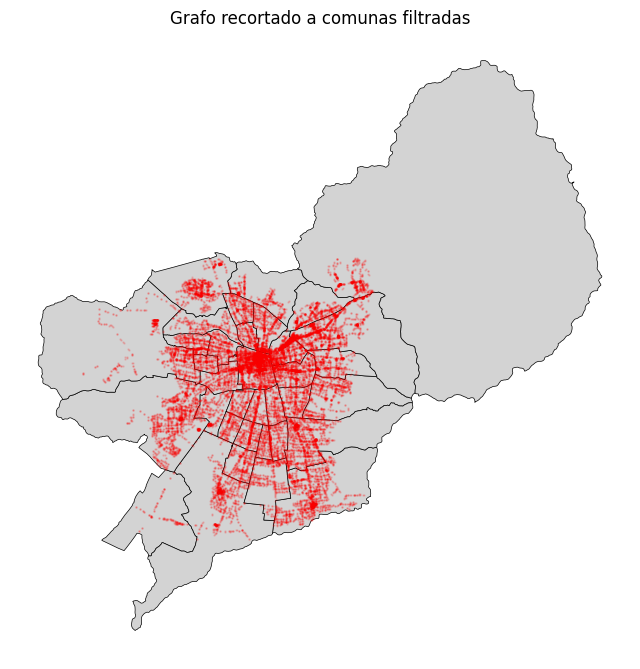

In [7]:
nodes_data_clip = []
for node_id, attrs in G_clip.nodes(data=True):
    lat = attrs.get("lat", None)
    lon = attrs.get("lon", None)
    if lat is None or lon is None:
        continue
    nodes_data_clip.append({
        "node_id": node_id,
        "lat": float(lat),
        "lon": float(lon),
        "tipo": attrs.get("tipo", None),
        "nombre": attrs.get("nombre", None),
    })

nodes_df_clip = pd.DataFrame(nodes_data_clip)

gdf_nodes_clip_plot = gpd.GeoDataFrame(
    nodes_df_clip,
    geometry=gpd.points_from_xy(nodes_df_clip["lon"], nodes_df_clip["lat"]),
    crs="EPSG:4326"
)
if gdf_nodes_clip_plot.crs != comunas_filtradas.crs:
    gdf_nodes_clip_plot = gdf_nodes_clip_plot.to_crs(comunas_filtradas.crs)


fig, ax = plt.subplots(figsize=(8, 24))
comunas_filtradas.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    linewidth=0.5
)
gdf_nodes_clip_plot.plot(
    ax=ax,
    markersize=0.5,
    alpha=0.15,
    c='red'
)
ax.set_title("Grafo recortado a comunas filtradas", fontsize=12)
ax.set_axis_off()
plt.show()

In [8]:
# guardamos comunas relevantes, POI filtrados y grafo recortado
comunas_filtradas.to_file("../data/comunas_filtradas.gpkg", driver="GPKG")
poi_filtrado.to_csv("../data/poi_filtrados.csv", index=False)
nx.write_gexf(G_clip, "../data/grafo_OSM/grafo_santiago_filtrado.gexf")